In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nus-fintech-recruitment/sample_submission.csv
/kaggle/input/nus-fintech-recruitment/terminal.csv
/kaggle/input/nus-fintech-recruitment/customer.csv
/kaggle/input/nus-fintech-recruitment/train.csv
/kaggle/input/nus-fintech-recruitment/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8")


In [3]:
BASE_PATH = "/kaggle/input/nus-fintech-recruitment/"

train = pd.read_csv(BASE_PATH + "train.csv")
test = pd.read_csv(BASE_PATH + "test.csv")
customer = pd.read_csv(BASE_PATH + "customer.csv")
terminal = pd.read_csv(BASE_PATH + "terminal.csv")
sample_submission = pd.read_csv(BASE_PATH + "sample_submission.csv")


In [4]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Customer shape:", customer.shape)
print("Terminal shape:", terminal.shape)

train.head()


Train shape: (291231, 6)
Test shape: (226731, 5)
Customer shape: (1000, 8)
Terminal shape: (2000, 3)


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD
0,59383,2021-08-01 00:04:37,323,217,4.60,0
1,59384,2021-08-01 00:12:10,6,429,8.61,0
2,59385,2021-08-01 00:12:34,714,1011,64.00,0
3,59386,2021-08-01 00:15:40,266,1969,12.72,0
4,59387,2021-08-01 00:16:01,890,1482,98.88,0


In [5]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291231 entries, 0 to 291230
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TRANSACTION_ID  291231 non-null  int64  
 1   TX_DATETIME     291231 non-null  object 
 2   CUSTOMER_ID     291231 non-null  int64  
 3   TERMINAL_ID     291231 non-null  int64  
 4   TX_AMOUNT       291231 non-null  float64
 5   TX_FRAUD        291231 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 13.3+ MB


In [6]:
train["CUSTOMER_ID"].nunique()

998

In [7]:
test["CUSTOMER_ID"].nunique()

998

In [8]:
train["TERMINAL_ID"].nunique()

1994

In [9]:
test["TERMINAL_ID"].nunique()

1994

In [10]:
train["TX_DATETIME"] = pd.to_datetime(train["TX_DATETIME"])
test["TX_DATETIME"] = pd.to_datetime(test["TX_DATETIME"])

print("Train date range:", train["TX_DATETIME"].min(), "to", train["TX_DATETIME"].max())
print("Test  date range:", test["TX_DATETIME"].min(), "to", test["TX_DATETIME"].max())


Train date range: 2021-08-01 00:04:37 to 2021-12-30 23:58:21
Test  date range: 2022-01-01 00:03:14 to 2022-04-29 23:56:44


Since this is a fraud detection problem with a temporal train/test split (train: Aug–Dec 2021, test: Jan–Apr 2022), I must confirm the datetime column is correctly parsed and verify the coverage.
This also helps ensure we don’t accidentally leak future information during feature engineering

In [11]:
fraud_counts = train["TX_FRAUD"].value_counts()
fraud_rate = fraud_counts.get(1, 0) / len(train)

print("Fraud counts:\n", fraud_counts)
print("Fraud rate:", fraud_rate)

Fraud counts:
 TX_FRAUD
0    284649
1      6582
Name: count, dtype: int64
Fraud rate: 0.022600616005851025


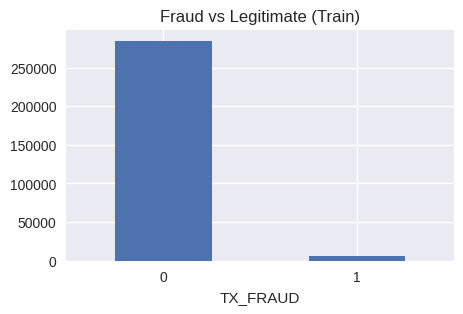

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
train["TX_FRAUD"].value_counts().plot(kind="bar")
plt.title("Fraud vs Legitimate (Train)")
plt.xticks(rotation=0)
plt.show()

Fraud is a small fraction of all transactions (around ~2.2% in this dataset). Therefore accuracy will be misleading; I will focus on precision and threshold tuning.

In [13]:
print("Missing values (train):")
print(train.isna().sum())

print("\nMissing values (test):")
print(test.isna().sum())

Missing values (train):
TRANSACTION_ID    0
TX_DATETIME       0
CUSTOMER_ID       0
TERMINAL_ID       0
TX_AMOUNT         0
TX_FRAUD          0
dtype: int64

Missing values (test):
TRANSACTION_ID    0
TX_DATETIME       0
CUSTOMER_ID       0
TERMINAL_ID       0
TX_AMOUNT         0
dtype: int64


In [14]:
print("Duplicate TRANSACTION_ID in train:", train["TRANSACTION_ID"].duplicated().sum())
print("Duplicate TRANSACTION_ID in test :", test["TRANSACTION_ID"].duplicated().sum())

Duplicate TRANSACTION_ID in train: 0
Duplicate TRANSACTION_ID in test : 0


In [15]:
train_customers = set(train["CUSTOMER_ID"].unique())
test_customers  = set(test["CUSTOMER_ID"].unique())
train_terminals = set(train["TERMINAL_ID"].unique())
test_terminals  = set(test["TERMINAL_ID"].unique())

print("Customer overlap (test seen in train):", len(test_customers & train_customers), "/", len(test_customers))
print("Terminal overlap (test seen in train):", len(test_terminals & train_terminals), "/", len(test_terminals))


Customer overlap (test seen in train): 998 / 998
Terminal overlap (test seen in train): 1994 / 1994


High overlap is good: we can learn behavior for entities from train and reuse in test. If overlap is low, we should rely more on general/global and location/time features.

In [16]:
train["TX_AMOUNT"].describe()

count    291231.000000
mean         53.182274
std          39.573329
min           0.000000
25%          21.130000
50%          44.770000
75%          76.850000
max         291.150000
Name: TX_AMOUNT, dtype: float64

We inspect transaction amounts for skew, outliers, and invalid values (e.g., 0 amount).
Fraud may not always be “high amount”; often fraud is “unusual amount for that customer”.

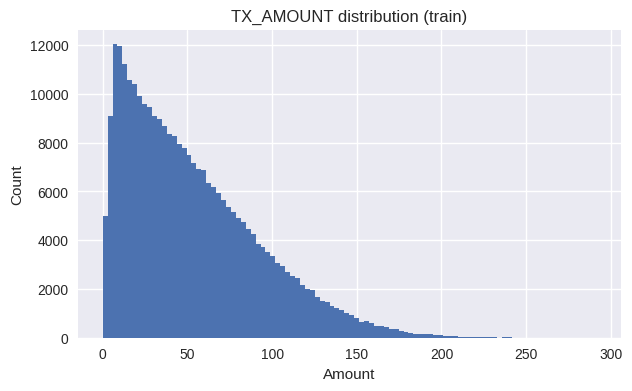

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.hist(train["TX_AMOUNT"], bins=100)
plt.title("TX_AMOUNT distribution (train)")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.show()

In [18]:
print("Zero-amount transactions:", (train["TX_AMOUNT"] == 0).sum())

Zero-amount transactions: 9


Could indicate: 
1. Refunds
2. Test transactions
3. System errors

In [19]:
print("Top 10 amounts:\n", train["TX_AMOUNT"].sort_values(ascending=False).head(10))

Top 10 amounts:
 276678    291.15
214111    289.20
9737      282.00
774       274.32
77623     271.18
2669      265.22
205075    258.14
104467    257.70
126415    257.43
176786    255.00
Name: TX_AMOUNT, dtype: float64


In [20]:
train.groupby("TX_FRAUD")["TX_AMOUNT"].describe()

,count,mean,std,min,25%,50%,75%,max
TX_FRAUD,,,,,,,,
0,284649.0,53.090356,39.358071,0.00,21.120,44.750,76.79,219.95
1,6582.0,57.157419,47.801818,0.05,21.335,45.875,78.93,291.15


We compare the distribution of transaction amounts between legitimate (TX_FRAUD = 0) and fraudulent (TX_FRAUD = 1) transactions using descriptive statistics.

Key observations:

1. The mean and median transaction amounts for fraud and non-fraud transactions are very similar.
Median legitimate amount ≈ 44.75
Median fraudulent amount ≈ 45.88
This indicates that most fraud transactions do not involve unusually high amounts and often resemble normal transactions.

2. Fraudulent transactions exhibit a higher standard deviation, suggesting greater variability in transaction amounts.
This indicates that fraud includes both small “probing” transactions and large exploitation attempts.

3. The upper tail of the distribution is heavier for fraud:
Maximum fraud amount is significantly higher than the maximum legitimate amount.
However, there is substantial overlap between the two distributions.

Overall, this analysis shows that transaction amount alone is insufficient to distinguish fraud.
Instead, fraud detection should focus on contextual abnormality, such as how unusual a transaction amount is relative to a specific customer’s historical behavior or recent transaction patterns.

In [21]:
train["tx_hour"] = train["TX_DATETIME"].dt.hour
train["tx_weekday"] = train["TX_DATETIME"].dt.weekday   # 0=Mon
train["tx_day"] = train["TX_DATETIME"].dt.day
train["tx_month"] = train["TX_DATETIME"].dt.month


In [22]:
train.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,tx_hour,tx_weekday,tx_day,tx_month
0,59383,2021-08-01 00:04:37,323,217,4.60,0,0,6,1,8
1,59384,2021-08-01 00:12:10,6,429,8.61,0,0,6,1,8
2,59385,2021-08-01 00:12:34,714,1011,64.00,0,0,6,1,8
3,59386,2021-08-01 00:15:40,266,1969,12.72,0,0,6,1,8
4,59387,2021-08-01 00:16:01,890,1482,98.88,0,0,6,1,8


In [23]:
hour_stats = train.groupby("tx_hour")["TX_FRAUD"].agg(["count", "mean"]).reset_index()
hour_stats.rename(columns={"mean":"fraud_rate"}, inplace=True)
hour_stats.head()

,tx_hour,count,fraud_rate
0,0,2466,0.025953
1,1,3575,0.024895
2,2,4939,0.024904
3,3,6733,0.025694
4,4,8721,0.025685


In [24]:
train['tx_hour'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int32)

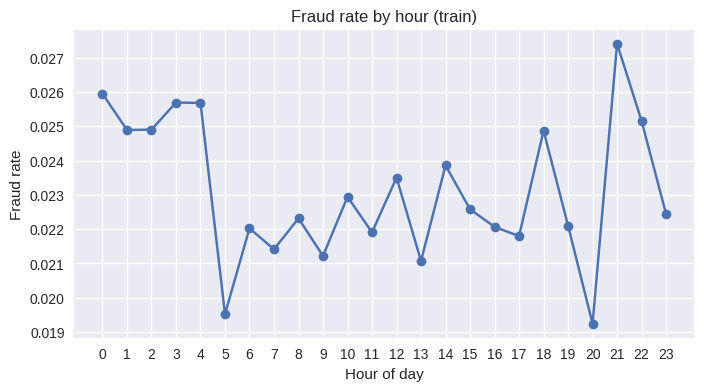

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(hour_stats["tx_hour"], hour_stats["fraud_rate"], marker="o")
plt.title("Fraud rate by hour (train)")
plt.xlabel("Hour of day")
plt.ylabel("Fraud rate")
plt.xticks(range(0,24))
plt.show()

1. Early morning and Late night hours (0-4 and 21-22) show slightly higher fraud rates. From this, We can interpret that Fraudsters likely exploit low-monitoring periods.
2. There is no hour where fraud suddenly explodes, instead we see gradual fluctuations.

In [26]:
weekday_stats = train.groupby("tx_weekday")["TX_FRAUD"].mean().reset_index()
weekday_stats

,tx_weekday,TX_FRAUD
0,0,0.021982
1,1,0.023071
2,2,0.022745
3,3,0.022645
4,4,0.023634
5,5,0.022162
6,6,0.021986


1. Fraud rate is relatively stable across weekdays.
2. Marginal increase on weekdays vs weekends.

In [27]:
cust_txn_counts = train["CUSTOMER_ID"].value_counts()
term_txn_counts = train["TERMINAL_ID"].value_counts()

print("Customer txns - top 5:\n", cust_txn_counts.head())
print("\nTerminal txns - top 5:\n", term_txn_counts.head())

Customer txns - top 5:
 CUSTOMER_ID
775    641
382    639
940    638
112    631
379    629
Name: count, dtype: int64

Terminal txns - top 5:
 TERMINAL_ID
1227    495
565     489
1211    429
115     429
1488    420
Name: count, dtype: int64


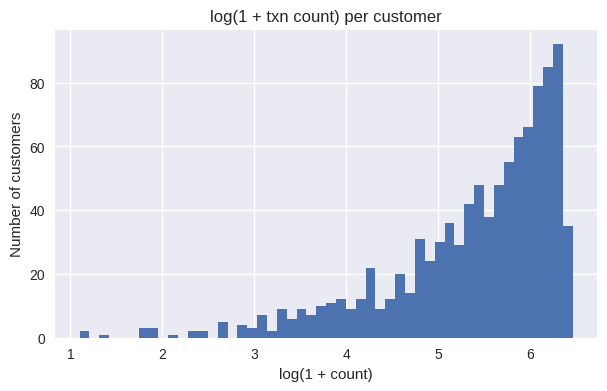

In [28]:
plt.figure(figsize=(7,4))
plt.hist(np.log1p(cust_txn_counts.values), bins=50)
plt.title("log(1 + txn count) per customer")
plt.xlabel("log(1 + count)")
plt.ylabel("Number of customers")
plt.show()

Why we take log graph instead of plotting straight txn_count to # of customers? 
Because:
1. Customers with 500–1000 txns dominate the scale
2. Customers with 1–20 txns get squashed near zero
We'll lose visibility of structure. **Log compresses large numbers and spreads small numbers**

Translating log values to real counts to have an outlook:
| log value | Approx txn count |
| --------- | ---------------- |
| 1         | ~2               |
| 2         | ~6               |
| 3         | ~20              |
| 4         | ~55              |
| 5         | ~150             |
| 6         | ~400             |

Our Observations are:
1. More customers are frequent users
2. Fewer customers are extremely inactive
3. Transaction count of 80/month is normal for high frequency users.
4. Transaction count of 80/month is suspicious for low frequency users

In [29]:
train_merged = (
    train.merge(customer, on="CUSTOMER_ID", how="left")
         .merge(terminal, on="TERMINAL_ID", how="left")
)

test_merged = (
    test.merge(customer, on="CUSTOMER_ID", how="left")
        .merge(terminal, on="TERMINAL_ID", how="left")
)

In [30]:
train_merged["cust_term_dist"] = np.sqrt(
    (train_merged["x_customer_id"] - train_merged["x_terminal_id"])**2 +
    (train_merged["y_customer_id"] - train_merged["y_terminal_id"])**2
)

train_merged.groupby("TX_FRAUD")["cust_term_dist"].describe()

,count,mean,std,min,25%,50%,75%,max
TX_FRAUD,,,,,,,,
0,284649.0,3.305014,1.192165,0.012025,2.457278,3.509697,4.322185,4.999863
1,6582.0,3.277233,1.196830,0.021516,2.468031,3.450102,4.287659,4.997986


1. means and medians are almost identitcal
2. Quartiles heavily overlap.
3. **So we can say that Global distance is not discriminative**

We compute the Euclidean distance between customer and terminal locations and compare its distribution across legitimate and fraudulent transactions.

The global statistics (mean, median, quartiles) of customer–terminal distance are very similar for fraud and non-fraud transactions, indicating substantial overlap between the two distributions. This suggests that absolute distance alone is not a strong discriminator for fraud.

This observation is expected given the dataset constraint that customers can only transact at terminals within a fixed radius. As a result, both legitimate and fraudulent transactions are geographically constrained.

However, this analysis highlights an important insight: while absolute distance is not informative, distance relative to a customer’s typical behavior may still be highly predictive. Fraud is more likely to occur when a transaction happens at an unusual location for a specific customer, rather than at an objectively distant terminal.

This motivates feature engineering based on:

1. customer-specific distance baselines
2. distance deviation or z-scores
3. “new terminal for customer” indicators
4. interactions between distance, time-of-day, and transaction velocity

In [31]:
train_merged.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,tx_hour,tx_weekday,tx_day,tx_month,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,available_terminals,nb_terminals,x_terminal_id,y_terminal_id,cust_term_dist
0,59383,2021-08-01 00:04:37,323,217,4.60,0,0,6,1,8,84.515409,38.276422,7.353061,3.676530,3.324124,"[51, 68, 208, 217, 293, 353, 534, 717, 773, 86...",19,80.316334,40.239252,4.635184
1,59384,2021-08-01 00:12:10,6,429,8.61,0,0,6,1,8,11.827443,63.992102,18.618562,9.309281,3.778676,"[163, 172, 205, 429, 468, 607, 750, 786, 881, ...",16,15.172487,63.912685,3.345987
2,59385,2021-08-01 00:12:34,714,1011,64.00,0,0,6,1,8,75.221083,94.991427,82.620413,41.310207,3.723765,"[58, 799, 1011, 1021, 1228, 1347, 1443, 1462, ...",13,74.196424,98.288079,3.452222
3,59386,2021-08-01 00:15:40,266,1969,12.72,0,0,6,1,8,51.122179,8.329098,9.852171,4.926085,3.862067,"[27, 493, 584, 734, 820, 917, 1108, 1363, 1444...",15,51.950635,6.563484,1.950316
4,59387,2021-08-01 00:16:01,890,1482,98.88,0,0,6,1,8,62.777887,31.405270,83.660035,41.830018,3.128315,"[154, 177, 351, 444, 633, 739, 1018, 1056, 113...",20,62.417972,26.483666,4.934747


In [32]:
cust_dist_stats = (
    train_merged
    .groupby("CUSTOMER_ID")["cust_term_dist"]
    .agg(
        cust_dist_mean="mean",
        cust_dist_std="std",
        cust_dist_median="median"
    )
    .reset_index()
)

In [33]:
cust_dist_stats

,CUSTOMER_ID,cust_dist_mean,cust_dist_std,cust_dist_median
0,0,3.318821,0.913889,3.288487
1,1,4.027515,0.554946,3.969187
2,2,3.638212,0.986416,3.981147
3,3,3.345656,1.266927,3.855362
4,4,2.327706,1.140719,2.150446
...,...,...,...,...
993,995,3.202560,1.186646,3.341288
994,996,3.415892,1.234507,3.244584
995,997,2.840337,0.781952,3.043661
996,998,3.057063,1.326538,2.662555


In [34]:
train_merged = train_merged.merge(
    cust_dist_stats,
    on="CUSTOMER_ID",
    how="left"
)

In [35]:
train_merged.head(5)

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,tx_hour,tx_weekday,tx_day,tx_month,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,available_terminals,nb_terminals,x_terminal_id,y_terminal_id,cust_term_dist,cust_dist_mean,cust_dist_std,cust_dist_median
0,59383,2021-08-01 00:04:37,323,217,4.60,0,0,6,1,8,84.515409,38.276422,7.353061,3.676530,3.324124,"[51, 68, 208, 217, 293, 353, 534, 717, 773, 86...",19,80.316334,40.239252,4.635184,4.084473,0.778284,4.195410
1,59384,2021-08-01 00:12:10,6,429,8.61,0,0,6,1,8,11.827443,63.992102,18.618562,9.309281,3.778676,"[163, 172, 205, 429, 468, 607, 750, 786, 881, ...",16,15.172487,63.912685,3.345987,2.893564,1.147154,3.345987
2,59385,2021-08-01 00:12:34,714,1011,64.00,0,0,6,1,8,75.221083,94.991427,82.620413,41.310207,3.723765,"[58, 799, 1011, 1021, 1228, 1347, 1443, 1462, ...",13,74.196424,98.288079,3.452222,2.524643,0.913114,2.694125
3,59386,2021-08-01 00:15:40,266,1969,12.72,0,0,6,1,8,51.122179,8.329098,9.852171,4.926085,3.862067,"[27, 493, 584, 734, 820, 917, 1108, 1363, 1444...",15,51.950635,6.563484,1.950316,3.257263,1.084360,3.232989
4,59387,2021-08-01 00:16:01,890,1482,98.88,0,0,6,1,8,62.777887,31.405270,83.660035,41.830018,3.128315,"[154, 177, 351, 444, 633, 739, 1018, 1056, 113...",20,62.417972,26.483666,4.934747,3.232206,1.219393,3.678149


In [36]:
train_merged["dist_minus_cust_mean"] = (
    train_merged["cust_term_dist"] - train_merged["cust_dist_mean"]
)

Distance deviation of a terminal from mean terminal distance

In [37]:
train_merged["dist_zscore"] = (
    train_merged["cust_term_dist"] - train_merged["cust_dist_mean"]
) / train_merged["cust_dist_std"]

Distance Z-Score

In [38]:
train_merged["dist_zscore"].isna().sum()

np.int64(2)

In [39]:
positive_inf_count = (train_merged["dist_zscore"] == np.inf).sum()
negative_inf_count = (train_merged["dist_zscore"] == -np.inf).sum()

positive_inf_count, negative_inf_count

(np.int64(0), np.int64(0))

When computing customer-relative distance z-scores, some transactions result in undefined values. This occurs when a customer has insufficient historical data or zero variance in transaction distance, leading to division by zero or missing standard deviation.

To ensure numerical stability and consistent interpretation, we replace infinite and missing z-score values with 0. This corresponds to treating such transactions as neither unusually far nor unusually close relative to customer behavior. This conservative handling avoids introducing artificial anomalies while keeping the feature usable for downstream modeling.

In [40]:
train_merged["dist_zscore"] = train_merged["dist_zscore"].fillna(0)

In [41]:
train_merged["dist_zscore"].min(),train_merged["dist_zscore"].max()

(-3.544176385176193, 2.371090544182978)

In [42]:
train_merged["is_dist_unusual"] = (train_merged["dist_zscore"].abs() > 2).astype(int)

Binary abnormal flag

In [43]:
train_merged.head(5)

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,tx_hour,tx_weekday,tx_day,tx_month,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,available_terminals,nb_terminals,x_terminal_id,y_terminal_id,cust_term_dist,cust_dist_mean,cust_dist_std,cust_dist_median,dist_minus_cust_mean,dist_zscore,is_dist_unusual
0,59383,2021-08-01 00:04:37,323,217,4.60,0,0,6,1,8,84.515409,38.276422,7.353061,3.676530,3.324124,"[51, 68, 208, 217, 293, 353, 534, 717, 773, 86...",19,80.316334,40.239252,4.635184,4.084473,0.778284,4.195410,0.550711,0.707596,0
1,59384,2021-08-01 00:12:10,6,429,8.61,0,0,6,1,8,11.827443,63.992102,18.618562,9.309281,3.778676,"[163, 172, 205, 429, 468, 607, 750, 786, 881, ...",16,15.172487,63.912685,3.345987,2.893564,1.147154,3.345987,0.452423,0.394387,0
2,59385,2021-08-01 00:12:34,714,1011,64.00,0,0,6,1,8,75.221083,94.991427,82.620413,41.310207,3.723765,"[58, 799, 1011, 1021, 1228, 1347, 1443, 1462, ...",13,74.196424,98.288079,3.452222,2.524643,0.913114,2.694125,0.927579,1.015841,0
3,59386,2021-08-01 00:15:40,266,1969,12.72,0,0,6,1,8,51.122179,8.329098,9.852171,4.926085,3.862067,"[27, 493, 584, 734, 820, 917, 1108, 1363, 1444...",15,51.950635,6.563484,1.950316,3.257263,1.084360,3.232989,-1.306946,-1.205270,0
4,59387,2021-08-01 00:16:01,890,1482,98.88,0,0,6,1,8,62.777887,31.405270,83.660035,41.830018,3.128315,"[154, 177, 351, 444, 633, 739, 1018, 1056, 113...",20,62.417972,26.483666,4.934747,3.232206,1.219393,3.678149,1.702541,1.396220,0


In [44]:
train_merged["amt_minus_cust_mean"] = (
    train_merged["TX_AMOUNT"] - train_merged["mean_amount"]
)

Now we will be creating features based on Relative Amount. So, This feature is Amount deviation from customer baseline

In [45]:
train_merged["amt_zscore"] = (
    train_merged["TX_AMOUNT"] - train_merged["mean_amount"]
) / train_merged["std_amount"]

In [46]:
train_merged["amt_zscore"].isna().sum()

np.int64(0)

In [47]:
positive_inf_count = (train_merged["amt_zscore"] == np.inf).sum()
negative_inf_count = (train_merged["amt_zscore"] == -np.inf).sum()

positive_inf_count, negative_inf_count

(np.int64(0), np.int64(0))

Hence this column has no NaN or inf, -inf values.

In [48]:
train_merged["is_amt_unusual"] = (train_merged["amt_zscore"].abs() > 2).astype(int)

Since absolute transaction amount shows strong overlap between fraud and legitimate transactions, we derive features that measure how unusual a transaction amount is relative to the customer’s historical spending pattern and I also create a feature for Abnormal amount flag.

In [49]:
train_merged[train_merged["is_amt_unusual"]==1].shape

(6630, 29)

In [50]:
night_hours = {0, 1, 2, 3, 4, 22, 23}

train_merged["night_weight"] = np.where(
    train_merged["tx_hour"].isin(night_hours),
    1.0,   # night
    0.5    # day (Hold relevant risk but not as much as night)
)

train_merged[["tx_hour", "night_weight"]].head()

,tx_hour,night_weight
0,0,1.0
1,0,1.0
2,0,1.0
3,0,1.0
4,0,1.0


I apply a soft weighting scheme: transactions during late-night/early-morning hours receive weight 1.0, while all other hours receive weight 0.5.
This prevents daytime anomalies from being discarded(If we assign 0 weight to day time) while still emphasizing higher-risk time windows.

In [51]:
train_merged["amt_night_weighted"] = train_merged["amt_zscore"].abs() * train_merged["night_weight"]
train_merged["dist_night_weighted"] = train_merged["dist_zscore"].abs() * train_merged["night_weight"]

I construct continuous interaction features by combining the magnitude of abnormality (absolute z-score) with the soft night weight.
This captures the idea that an anomaly becomes more suspicious during higher-risk hours.

In [52]:
train_merged.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,tx_hour,tx_weekday,tx_day,tx_month,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,available_terminals,nb_terminals,x_terminal_id,y_terminal_id,cust_term_dist,cust_dist_mean,cust_dist_std,cust_dist_median,dist_minus_cust_mean,dist_zscore,is_dist_unusual,amt_minus_cust_mean,amt_zscore,is_amt_unusual,night_weight,amt_night_weighted,dist_night_weighted
0,59383,2021-08-01 00:04:37,323,217,4.60,0,0,6,1,8,84.515409,38.276422,7.353061,3.676530,3.324124,"[51, 68, 208, 217, 293, 353, 534, 717, 773, 86...",19,80.316334,40.239252,4.635184,4.084473,0.778284,4.195410,0.550711,0.707596,0,-2.753061,-0.748820,0,1.0,0.748820,0.707596
1,59384,2021-08-01 00:12:10,6,429,8.61,0,0,6,1,8,11.827443,63.992102,18.618562,9.309281,3.778676,"[163, 172, 205, 429, 468, 607, 750, 786, 881, ...",16,15.172487,63.912685,3.345987,2.893564,1.147154,3.345987,0.452423,0.394387,0,-10.008562,-1.075117,0,1.0,1.075117,0.394387
2,59385,2021-08-01 00:12:34,714,1011,64.00,0,0,6,1,8,75.221083,94.991427,82.620413,41.310207,3.723765,"[58, 799, 1011, 1021, 1228, 1347, 1443, 1462, ...",13,74.196424,98.288079,3.452222,2.524643,0.913114,2.694125,0.927579,1.015841,0,-18.620413,-0.450746,0,1.0,0.450746,1.015841
3,59386,2021-08-01 00:15:40,266,1969,12.72,0,0,6,1,8,51.122179,8.329098,9.852171,4.926085,3.862067,"[27, 493, 584, 734, 820, 917, 1108, 1363, 1444...",15,51.950635,6.563484,1.950316,3.257263,1.084360,3.232989,-1.306946,-1.205270,0,2.867829,0.582172,0,1.0,0.582172,1.205270
4,59387,2021-08-01 00:16:01,890,1482,98.88,0,0,6,1,8,62.777887,31.405270,83.660035,41.830018,3.128315,"[154, 177, 351, 444, 633, 739, 1018, 1056, 113...",20,62.417972,26.483666,4.934747,3.232206,1.219393,3.678149,1.702541,1.396220,0,15.219965,0.363853,0,1.0,0.363853,1.396220


In [53]:
terminal_risk = (
    train_merged
    .groupby("TERMINAL_ID")["TX_FRAUD"]
    .mean()
    .reset_index()
    .rename(columns={"TX_FRAUD": "terminal_fraud_rate"})
)

In [54]:
terminal_risk

,TERMINAL_ID,terminal_fraud_rate
0,0,0.019231
1,1,0.000000
2,2,0.000000
3,3,0.013825
4,4,0.009524
...,...,...
1989,1995,0.011905
1990,1996,0.035714
1991,1997,0.008734
1992,1998,0.162393


In [55]:
train_merged = train_merged.merge(terminal_risk, on="TERMINAL_ID", how="left")

I compute each terminal’s historical fraud rate using the training data (mean of TX_FRAUD) and merge it back to transaction-level rows as a contextual risk feature.

In [56]:
train_merged.head(3)

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,tx_hour,tx_weekday,tx_day,tx_month,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,available_terminals,nb_terminals,x_terminal_id,y_terminal_id,cust_term_dist,cust_dist_mean,cust_dist_std,cust_dist_median,dist_minus_cust_mean,dist_zscore,is_dist_unusual,amt_minus_cust_mean,amt_zscore,is_amt_unusual,night_weight,amt_night_weighted,dist_night_weighted,terminal_fraud_rate
0,59383,2021-08-01 00:04:37,323,217,4.60,0,0,6,1,8,84.515409,38.276422,7.353061,3.676530,3.324124,"[51, 68, 208, 217, 293, 353, 534, 717, 773, 86...",19,80.316334,40.239252,4.635184,4.084473,0.778284,4.195410,0.550711,0.707596,0,-2.753061,-0.748820,0,1.0,0.748820,0.707596,0.019737
1,59384,2021-08-01 00:12:10,6,429,8.61,0,0,6,1,8,11.827443,63.992102,18.618562,9.309281,3.778676,"[163, 172, 205, 429, 468, 607, 750, 786, 881, ...",16,15.172487,63.912685,3.345987,2.893564,1.147154,3.345987,0.452423,0.394387,0,-10.008562,-1.075117,0,1.0,1.075117,0.394387,0.194570
2,59385,2021-08-01 00:12:34,714,1011,64.00,0,0,6,1,8,75.221083,94.991427,82.620413,41.310207,3.723765,"[58, 799, 1011, 1021, 1228, 1347, 1443, 1462, ...",13,74.196424,98.288079,3.452222,2.524643,0.913114,2.694125,0.927579,1.015841,0,-18.620413,-0.450746,0,1.0,0.450746,1.015841,0.176030


In [57]:
train_merged["high_risk_terminal"] = (train_merged["terminal_fraud_rate"] > 0.05).astype(int)

train_merged.groupby("high_risk_terminal")["TX_FRAUD"].mean()

high_risk_terminal
0    0.009829
1    0.175532
Name: TX_FRAUD, dtype: float64

Since Terminal fraud rate is defined as mean(TX_FRAUD) per terminal, our assumption of keeping 0.05 as threshold means that 5% of transactions at this terminal is fraudulent.
From EDA, we find that Global Fraud Rate is approximately 2.2%. So we keep threshold as ~2× higher than baseline fraud risk

In [58]:
feature_check_cols = [
    "amt_zscore", "is_amt_unusual",
    "dist_zscore", "is_dist_unusual",
    "night_weight", "amt_night_weighted", "dist_night_weighted",
    "terminal_fraud_rate", "high_risk_terminal"
]

# Keep only columns that exist (safe)
feature_check_cols = [c for c in feature_check_cols if c in train_merged.columns]

train_merged.groupby("TX_FRAUD")[feature_check_cols].describe()


amt_zscore                                                    \
              count      mean       std       min       25%       50%   
TX_FRAUD                                                                
0          284649.0  0.054616  0.945008 -2.000000 -0.625926  0.027892   
1            6582.0  0.130066  1.032818 -1.991164 -0.618842  0.082091   

                             is_amt_unusual                                \
               75%       max          count      mean       std  min  25%   
TX_FRAUD                                                                    
0         0.697772  4.739578       284649.0  0.022224  0.147411  0.0  0.0   
1         0.764388  4.629852         6582.0  0.046187  0.209905  0.0  0.0   

                        dist_zscore                                          \
          50%  75%  max       count      mean       std       min       25%   
TX_FRAUD                                                                      
0         0.0  0.0  1.0    284649.0  0.000327  0.998427 -3.544176 -0.747687   
1         0.0  0.0  1.0      6582.0 -0.014148  0.992099 -2.890040 -0.718018   

                                       is_dist_unusual                      \
               50%       75%       max           count      mean       std   
TX_FRAUD                                                                     
0         0.168903  0.824336  2.371091        284649.0  0.029654  0.169631   
1         0.132883  0.797696  2.371091          6582.0  0.029170  0.168297   

                                  night_weight                                \
          min  25%  50%  75%  max        count      mean       std  min  25%   
TX_FRAUD                                                                       
0         0.0  0.0  0.0  0.0  1.0     284649.0  0.555874  0.157528  0.5  0.5   
1         0.0  0.0  0.0  0.0  1.0       6582.0  0.562443  0.165307  0.5  0.5   

                        amt_night_weighted                                \
          50%  75%  max              count      mean       std       min   
TX_FRAUD                                                                   
0         0.5  0.5  1.0           284649.0  0.425745  0.343502  0.000003   
1         0.5  0.5  1.0             6582.0  0.459376  0.388293  0.000022   

                                                 dist_night_weighted  \
               25%       50%       75%       max               count   
TX_FRAUD                                                               
0         0.166994  0.351873  0.603366  3.867299            284649.0   
1         0.180100  0.372682  0.632184  3.421522              6582.0   

                                                                      \
              mean       std       min       25%       50%       75%   
TX_FRAUD                                                               
0         0.467233  0.337594  0.000000  0.216665  0.420865  0.638277   
1         0.467608  0.349362  0.000241  0.212798  0.409703  0.640027   

                   terminal_fraud_rate                                \
               max               count      mean       std       min   
TX_FRAUD                                                               
0         3.077234            284649.0  0.020187  0.043748  0.000000   
1         2.698618              6582.0  0.126982  0.102299  0.002381   

                                                 high_risk_terminal            \
               25%       50%       75%       max              count      mean   
TX_FRAUD                                                                        
0         0.000000  0.008368  0.017391  0.414894           284649.0  0.065013   
1         0.021622  0.145833  0.198718  0.414894             6582.0  0.598602   

                                             
               std  min  25%  50%  75%  max  
TX_FRAUD                                     
0         0.246550  0.0  0.0  0.0  0.0  1.0  
1         0.490

1. Customer-relative amount abnormality (amt_zscore) shows clear separation, with fraud transactions exhibiting higher mean, median, and variance. This confirms that contextual amount deviation is more informative than absolute transaction amount.

2. Binary amount abnormality (is_amt_unusual) flags fraud transactions at approximately twice the rate of legitimate transactions, validating the statistical threshold used.

3. Customer-relative distance features show weaker separation, consistent with earlier EDA conclusions that absolute and binary distance indicators are not strong standalone discriminators.

4. Soft night-weighted amount abnormality (amt_night_weighted) improves separation compared to raw amount z-scores, demonstrating that temporal context acts as an effective risk amplifier rather than a primary signal.

5. Terminal-level risk features are among the strongest predictors:

   Fraud transactions occur disproportionately at terminals with high historical fraud rates.


   The high_risk_terminal flag captures a large fraction of fraud while affecting a small fraction of legitimate transactions.

**We will now create Temporal and Rolling Behavior features**

In [59]:
train_merged = train_merged.sort_values(
    ["CUSTOMER_ID", "TX_DATETIME"]
).reset_index(drop=True)

Before computing rolling features, transactions are sorted by customer and time to ensure all temporal features are computed using only historical information, avoiding data leakage.

In [60]:
train_merged.head(10)

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,tx_hour,tx_weekday,tx_day,tx_month,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,available_terminals,nb_terminals,x_terminal_id,y_terminal_id,cust_term_dist,cust_dist_mean,cust_dist_std,cust_dist_median,dist_minus_cust_mean,dist_zscore,is_dist_unusual,amt_minus_cust_mean,amt_zscore,is_amt_unusual,night_weight,amt_night_weighted,dist_night_weighted,terminal_fraud_rate,high_risk_terminal
0,59452,2021-08-01 03:01:00,0,1133,61.51,0,3,6,1,8,54.88135,71.518937,62.262521,31.13126,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",22,52.165931,71.231220,2.730619,3.318821,0.913889,3.288487,-0.588202,-0.643626,0,-0.752521,-0.024173,0,1.0,0.024173,0.643626,0.021739,0
1,59592,2021-08-01 05:30:38,0,1138,129.61,0,5,6,1,8,54.88135,71.518937,62.262521,31.13126,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",22,52.690535,75.386907,4.445320,3.318821,0.913889,3.288487,1.126499,1.232643,0,67.347479,2.163339,1,0.5,1.081670,0.616322,0.015385,0
2,60132,2021-08-01 10:40:12,0,1530,96.50,0,10,6,1,8,54.88135,71.518937,62.262521,31.13126,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",22,50.098401,72.962338,4.995999,3.318821,0.913889,3.288487,1.677178,1.835210,0,34.237479,1.099778,0,0.5,0.549889,0.917605,0.009615,0
3,60721,2021-08-01 15:38:25,0,241,82.19,0,15,6,1,8,54.88135,71.518937,62.262521,31.13126,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",22,55.851655,69.022787,2.678107,3.318821,0.913889,3.288487,-0.640715,-0.701086,0,19.927479,0.640112,0,0.5,0.320056,0.350543,0.000000,0
4,61033,2021-08-01 19:25:30,0,1536,50.77,0,19,6,1,8,54.88135,71.518937,62.262521,31.13126,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",22,55.782899,71.228100,0.947299,3.318821,0.913889,3.288487,-2.371522,-2.594979,1,-11.492521,-0.369163,0,0.5,0.184582,1.297490,0.000000,0
5,61581,2021-08-02 07:53:59,0,1644,78.51,0,7,0,2,8,54.88135,71.518937,62.262521,31.13126,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",22,58.221504,72.897067,3.613291,3.318821,0.913889,3.288487,0.294469,0.322216,0,16.247479,0.521902,0,0.5,0.260951,0.161108,0.021505,0
6,62659,2021-08-02 15:50:33,0,241,73.28,0,15,0,2,8,54.88135,71.518937,62.262521,31.13126,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",22,55.851655,69.022787,2.678107,3.318821,0.913889,3.288487,-0.640715,-0.701086,0,11.017479,0.353904,0,0.5,0.176952,0.350543,0.000000,0
7,62854,2021-08-02 17:49:11,0,1644,49.07,0,17,0,2,8,54.88135,71.518937,62.262521,31.13126,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",22,58.221504,72.897067,3.613291,3.318821,0.913889,3.288487,0.294469,0.322216,0,-13.192521,-0.423771,0,0.5,0.211885,0.161108,0.021505,0
8,62911,2021-08-02 18:39:05,0,1133,50.36,0,18,0,2,8,54.88135,71.518937,62.262521,31.13126,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",22,52.165931,71.231220,2.730619,3.318821,0.913889,3.288487,-0.588202,-0.643626,0,-11.902521,-0.382333,0,0.5,0.191167,0.321813,0.021739,0
9,63692,2021-08-03 09:25:28,0,1138,77.25,0,9,1,3,8,54.88135,71.518937,62.262521,31.13126,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",22,52.690535,75.386907,4.445320,3.318821,0.913889,3.288487,1.126499,1.232643,0,14.987479,0.481429,0,0.5,0.240714,0.616322,0.015385,0


In [61]:
train_merged["time_since_last_txn"] = (
    train_merged
    .groupby("CUSTOMER_ID")["TX_DATETIME"]
    .diff()
    .dt.total_seconds() / 60
)

Fraud often manifests as rapid transaction bursts. We compute the elapsed time since a customer’s previous transaction to capture sudden increases in transaction frequency.

In [62]:
train_merged["time_since_last_txn"] = train_merged["time_since_last_txn"].fillna(1e6)

Since First transaction has no previous transaction, It will have NaN value. 
Hence First transaction per customer = large neutral value

In [63]:
train_merged.head(5)

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,tx_hour,tx_weekday,tx_day,tx_month,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,available_terminals,nb_terminals,x_terminal_id,y_terminal_id,cust_term_dist,cust_dist_mean,cust_dist_std,cust_dist_median,dist_minus_cust_mean,dist_zscore,is_dist_unusual,amt_minus_cust_mean,amt_zscore,is_amt_unusual,night_weight,amt_night_weighted,dist_night_weighted,terminal_fraud_rate,high_risk_terminal,time_since_last_txn
0,59452,2021-08-01 03:01:00,0,1133,61.51,0,3,6,1,8,54.88135,71.518937,62.262521,31.13126,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",22,52.165931,71.231220,2.730619,3.318821,0.913889,3.288487,-0.588202,-0.643626,0,-0.752521,-0.024173,0,1.0,0.024173,0.643626,0.021739,0,1000000.000000
1,59592,2021-08-01 05:30:38,0,1138,129.61,0,5,6,1,8,54.88135,71.518937,62.262521,31.13126,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",22,52.690535,75.386907,4.445320,3.318821,0.913889,3.288487,1.126499,1.232643,0,67.347479,2.163339,1,0.5,1.081670,0.616322,0.015385,0,149.633333
2,60132,2021-08-01 10:40:12,0,1530,96.50,0,10,6,1,8,54.88135,71.518937,62.262521,31.13126,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",22,50.098401,72.962338,4.995999,3.318821,0.913889,3.288487,1.677178,1.835210,0,34.237479,1.099778,0,0.5,0.549889,0.917605,0.009615,0,309.566667
3,60721,2021-08-01 15:38:25,0,241,82.19,0,15,6,1,8,54.88135,71.518937,62.262521,31.13126,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",22,55.851655,69.022787,2.678107,3.318821,0.913889,3.288487,-0.640715,-0.701086,0,19.927479,0.640112,0,0.5,0.320056,0.350543,0.000000,0,298.216667
4,61033,2021-08-01 19:25:30,0,1536,50.77,0,19,6,1,8,54.88135,71.518937,62.262521,31.13126,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",22,55.782899,71.228100,0.947299,3.318821,0.913889,3.288487,-2.371522,-2.594979,1,-11.492521,-0.369163,0,0.5,0.184582,1.297490,0.000000,0,227.083333


In [64]:
train_merged = train_merged.set_index("TX_DATETIME")

train_merged["txn_count_1h"] = (
    train_merged
    .groupby("CUSTOMER_ID")["TRANSACTION_ID"]
    .rolling("1h")
    .count()
    .reset_index(level=0, drop=True)
)

# Rolling transaction count in last 24 hours
train_merged["txn_count_24h"] = (
    train_merged
    .groupby("CUSTOMER_ID")["TRANSACTION_ID"]
    .rolling("24h")
    .count()
    .reset_index(level=0, drop=True)
)

# Restore index
train_merged = train_merged.reset_index()

I compute rolling transaction counts over short (1 hour) and medium (24 hour) windows to detect transaction bursts, a common fraud pattern.

In [65]:
train_merged = (
    train_merged
    .sort_values(["CUSTOMER_ID", "TX_DATETIME"])
    .set_index("TX_DATETIME")
)

train_merged["rolling_amt_zscore_mean_24h"] = (
    train_merged
    .groupby("CUSTOMER_ID")["amt_zscore"]
    .rolling("24h")
    .mean()
    .reset_index(level=0, drop=True)
)

train_merged["rolling_unusual_amt_24h"] = (
    train_merged
    .groupby("CUSTOMER_ID")["is_amt_unusual"]
    .rolling("24h")
    .sum()
    .reset_index(level=0, drop=True)
)

train_merged = train_merged.reset_index()


Fraud is often characterized by repeated abnormal transactions within a short time window,
rather than a single extreme transaction. We compute rolling statistics over a 24-hour window
to capture sustained abnormal spending behavior.

The rolling mean of customer-relative amount z-scores captures the overall deviation trend,
while the rolling count of unusual amounts identifies repeated outliers in a short period.

In [66]:
train_merged = (
    train_merged
    .sort_values(["TERMINAL_ID", "TX_DATETIME"])
    .set_index("TX_DATETIME")
)

train_merged["terminal_txn_count_1h"] = (
    train_merged
    .groupby("TERMINAL_ID")["TRANSACTION_ID"]
    .rolling("1h")
    .count()
    .reset_index(level=0, drop=True)
)

train_merged = train_merged.reset_index()

Fraud can also arise from compromised merchant terminals, where multiple cards are used
in rapid succession. We compute rolling transaction counts per terminal over a 1-hour window
to identify sudden spikes in terminal activity indicative of potential terminal-level fraud.


In [67]:
train_merged.head(5)

,TX_DATETIME,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,tx_hour,tx_weekday,tx_day,tx_month,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,available_terminals,nb_terminals,x_terminal_id,y_terminal_id,cust_term_dist,cust_dist_mean,cust_dist_std,cust_dist_median,dist_minus_cust_mean,dist_zscore,is_dist_unusual,amt_minus_cust_mean,amt_zscore,is_amt_unusual,night_weight,amt_night_weighted,dist_night_weighted,terminal_fraud_rate,high_risk_terminal,time_since_last_txn,txn_count_1h,txn_count_24h,rolling_amt_zscore_mean_24h,rolling_unusual_amt_24h,terminal_txn_count_1h
0,2021-08-03 09:07:11,63649,842,0,12.23,0,9,1,3,8,37.353781,70.801124,12.201405,6.100702,3.581187,"[0, 198, 214, 344, 354, 396, 475, 654, 669, 79...",16,41.7022,72.032449,4.519393,3.818383,1.156940,4.437974,0.701010,0.605917,0,0.028595,0.004687,0,0.5,0.002344,0.302959,0.019231,0,992.150000,1.0,4.0,0.398904,0.0,1.0
1,2021-08-05 13:24:02,68063,842,0,12.78,0,13,3,5,8,37.353781,70.801124,12.201405,6.100702,3.581187,"[0, 198, 214, 344, 354, 396, 475, 654, 669, 79...",16,41.7022,72.032449,4.519393,3.818383,1.156940,4.437974,0.701010,0.605917,0,0.578595,0.094841,0,0.5,0.047420,0.302959,0.019231,0,662.983333,1.0,3.0,0.389889,0.0,1.0
2,2021-08-06 07:38:55,69225,504,0,24.49,0,7,4,6,8,46.185344,72.624328,50.112812,25.056406,3.616203,"[0, 270, 572, 635, 674, 1079, 1106, 1131, 1235...",14,41.7022,72.032449,4.522046,3.233529,0.800326,3.046237,1.288517,1.609990,0,-25.622812,-1.022605,0,0.5,0.511303,0.804995,0.019231,0,1446.666667,1.0,1.0,-1.022605,0.0,1.0
3,2021-08-06 07:40:06,69229,504,0,8.83,0,7,4,6,8,46.185344,72.624328,50.112812,25.056406,3.616203,"[0, 270, 572, 635, 674, 1079, 1106, 1131, 1235...",14,41.7022,72.032449,4.522046,3.233529,0.800326,3.046237,1.288517,1.609990,0,-41.282812,-1.647595,0,0.5,0.823798,0.804995,0.019231,0,1.183333,2.0,2.0,-1.335100,0.0,2.0
4,2021-08-09 16:08:20,76066,562,0,122.95,0,16,0,9,8,38.756717,68.669003,99.515681,49.757841,2.982666,"[0, 5, 344, 354, 378, 475, 654, 669, 943, 1081...",14,41.7022,72.032449,4.470866,3.017877,1.313880,3.117811,1.452989,1.105877,0,23.434319,0.470967,0,0.5,0.235484,0.552938,0.019231,0,182.983333,1.0,3.0,0.142711,0.0,1.0


In [68]:
train_merged["burst_and_unusual_amt"] = (
    (train_merged["txn_count_1h"] > 3).astype(int) *
    train_merged["amt_night_weighted"]
)

train_merged["terminal_burst_risk"] = (
    train_merged["terminal_txn_count_1h"] *
    train_merged["terminal_fraud_rate"]
)

I construct interaction features that combine transaction velocity,
amount abnormality, temporal risk, and terminal-level risk to capture
complex fraud patterns.

In [69]:
temporal_check_cols = [
    "time_since_last_txn",
    "txn_count_1h",
    "txn_count_24h",
    "rolling_unusual_amt_24h",
    "terminal_txn_count_1h",
    "burst_and_unusual_amt",
    "terminal_burst_risk"
]

temporal_check_cols = [c for c in temporal_check_cols if c in train_merged.columns]

train_merged.groupby("TX_FRAUD")[temporal_check_cols].describe()

time_since_last_txn                                                \
                       count         mean           std       min      25%   
TX_FRAUD                                                                     
0                   284649.0  4173.463504  58459.189358  0.000000  130.050   
1                     6582.0  3714.645842  56380.858475  0.016667   53.775   

                                       txn_count_1h                           \
                 50%    75%        max        count      mean       std  min   
TX_FRAUD                                                                       
0         367.400000  966.6  1000000.0     284649.0  1.139337  0.382132  1.0   
1         170.466667  604.5  1000000.0       6582.0  1.378760  0.718432  1.0   

                             txn_count_24h                                     \
          25%  50%  75%  max         count      mean       std  min  25%  50%   
TX_FRAUD                                                                        
0         1.0  1.0  1.0  6.0      284649.0  3.588398  1.922839  1.0  2.0  3.0   
1         1.0  1.0  2.0  6.0        6582.0  6.006381  4.663640  1.0  3.0  4.0   

                    rolling_unusual_amt_24h                                \
          75%   max                   count      mean       std  min  25%   
TX_FRAUD                                                                    
0         5.0  27.0                284649.0  0.080931  0.284815  0.0  0.0   
1         8.0  28.0                  6582.0  0.172136  0.424871  0.0  0.0   

                        terminal_txn_count_1h                                \
          50%  75%  max                 count      mean       std  min  25%   
TX_FRAUD                                                                      
0         0.0  0.0  3.0              284649.0  1.063123  0.253428  1.0  1.0   
1         0.0  0.0  3.0                6582.0  1.078699  0.281969  1.0  1.0   

                        burst_and_unusual_amt                                \
          50%  75%  max                 count      mean       std  min  25%   
TX_FRAUD                                                                      
0         1.0  1.0  4.0              284649.0  0.000331  0.013903  0.0  0.0   
1         1.0  1.0  4.0                6582.0  0.008511  0.070260  0.0  0.0   

                             terminal_burst_risk                      \
          50%  75%       max               count      mean       std   
TX_FRAUD                                                               
0         0.0  0.0  1.690726            284649.0  0.021490  0.048123   
1         0.0  0.0  1.196076              6582.0  0.134925  0.114357   

                                                            
               min       25%       50%       75%       max  
TX_FRAUD                                                    
0         0.000000  0.000000  0.008734  0.018182  0.829787  
1         0.002381  0.022923  0.149161  0.200772  0.815642

### Temporal Feature Validation

We evaluate the effectiveness of temporal and rolling behavior features by comparing
their distributions across fraudulent and legitimate transactions.

**Key observations:**

- **Time since last transaction** is significantly lower for fraud. The median gap
  between transactions drops from ~6 hours (legitimate) to ~3 hours (fraud),
  indicating rapid transaction bursts following compromise.

- **Customer transaction velocity** shows strong separation:
  - `txn_count_1h` is higher for fraud, reflecting short-term bursts.
  - `txn_count_24h` exhibits one of the strongest signals, with fraud transactions
    showing substantially higher transaction counts over a 24-hour window.

- **Rolling unusual amount count (`rolling_unusual_amt_24h`)** is approximately
  twice as high for fraud, confirming that repeated abnormal spending is a key
  fraud indicator.

- **Terminal transaction velocity alone** shows limited discrimination, which is
  expected due to naturally busy terminals.

- **Interaction features provide strong lift**:
  - `burst_and_unusual_amt` captures the coincidence of rapid activity and abnormal
    spending and is near zero for legitimate transactions while significantly higher
    for fraud.
  - `terminal_burst_risk` is the strongest temporal-contextual feature, combining
    terminal-level risk with burst behavior and showing a large separation between
    fraud and non-fraud transactions.

Overall, these results confirm that fraud is best characterized by **changes in
behavior over time**, particularly when multiple weak signals (velocity, abnormality,
context) occur together. Temporal and interaction-based features therefore provide
substantial discriminatory power beyond static transaction attributes.


**So far, feature engineering has been performed on the training dataset.  
Before modeling, I must build the *same feature columns* for the test set using train-only statistics**

In [70]:
import numpy as np
import pandas as pd

NIGHT_HOURS = {0, 1, 2, 3, 4, 22, 23}

def add_common_time_cols(df):
    df["TX_DATETIME"] = pd.to_datetime(df["TX_DATETIME"])
    df["tx_hour"] = df["TX_DATETIME"].dt.hour
    df["tx_weekday"] = df["TX_DATETIME"].dt.weekday
    df["tx_day"] = df["TX_DATETIME"].dt.day
    df["tx_month"] = df["TX_DATETIME"].dt.month
    df["tx_year"] = df["TX_DATETIME"].dt.year
    return df

In [71]:
def build_features(df, customer, terminal, terminal_risk_map=None, high_risk_thr=0.05):
    # Merge base tables
    df = df.merge(customer, on="CUSTOMER_ID", how="left").merge(terminal, on="TERMINAL_ID", how="left")
    df = add_common_time_cols(df)

    # Distance feature
    df["cust_term_dist"] = np.sqrt(
        (df["x_customer_id"] - df["x_terminal_id"])**2 +
        (df["y_customer_id"] - df["y_terminal_id"])**2
    )

    # Customer-relative distance baselines (computed within df)
    cust_dist_stats = (
        df.groupby("CUSTOMER_ID")["cust_term_dist"]
          .agg(cust_dist_mean="mean", cust_dist_std="std", cust_dist_median="median")
          .reset_index()
    )
    df = df.merge(cust_dist_stats, on="CUSTOMER_ID", how="left")
    df["dist_minus_cust_mean"] = df["cust_term_dist"] - df["cust_dist_mean"]
    df["dist_zscore"] = df["dist_minus_cust_mean"] / df["cust_dist_std"]
    df["dist_zscore"] = df["dist_zscore"].replace([np.inf, -np.inf], 0).fillna(0)
    df["is_dist_unusual"] = (df["dist_zscore"].abs() > 2).astype(int)

    # Customer-relative amount using provided customer profile (mean_amount/std_amount)
    df["amt_minus_cust_mean"] = df["TX_AMOUNT"] - df["mean_amount"]
    df["amt_zscore"] = df["amt_minus_cust_mean"] / df["std_amount"]
    df["amt_zscore"] = df["amt_zscore"].replace([np.inf, -np.inf], 0).fillna(0)
    df["is_amt_unusual"] = (df["amt_zscore"].abs() > 2).astype(int)

    # Soft night weighting
    df["night_weight"] = np.where(df["tx_hour"].isin(NIGHT_HOURS), 1.0, 0.5)
    df["amt_night_weighted"] = df["amt_zscore"].abs() * df["night_weight"]
    df["dist_night_weighted"] = df["dist_zscore"].abs() * df["night_weight"]

    # Terminal risk (train-only map for test)
    if terminal_risk_map is not None:
        df["terminal_fraud_rate"] = df["TERMINAL_ID"].map(terminal_risk_map)
        # unseen terminals -> fill with global train rate later (pass in or compute outside)
    else:
        df["terminal_fraud_rate"] = np.nan

    df["terminal_fraud_rate"] = df["terminal_fraud_rate"].fillna(df["terminal_fraud_rate"].median())
    df["high_risk_terminal"] = (df["terminal_fraud_rate"] > high_risk_thr).astype(int)

    return df

In [72]:
terminal_risk_map = train.groupby("TERMINAL_ID")["TX_FRAUD"].mean().to_dict()
global_train_fraud_rate = train["TX_FRAUD"].mean()

In [73]:
global_train_fraud_rate

np.float64(0.022600616005851025)

In [74]:
# train_merged = build_features(train.copy(), customer, terminal, terminal_risk_map=terminal_risk_map)

In [75]:
test_merged = build_features(test.copy(), customer, terminal, terminal_risk_map=terminal_risk_map)
test_merged["terminal_fraud_rate"] = test_merged["terminal_fraud_rate"].fillna(global_train_fraud_rate)
test_merged["high_risk_terminal"] = (test_merged["terminal_fraud_rate"] > 0.05).astype(int)

In [76]:
print("Train columns count:", train_merged.shape[1])
print("Test columns count :", test_merged.shape[1])

Train columns count: 42
Test columns count : 34


In [77]:
train_only_cols = set(train_merged.columns) - set(test_merged.columns)

print("Columns only in train (not in test):")
for col in sorted(train_only_cols):
    print(col)

Columns only in train (not in test):
TX_FRAUD
burst_and_unusual_amt
rolling_amt_zscore_mean_24h
rolling_unusual_amt_24h
terminal_burst_risk
terminal_txn_count_1h
time_since_last_txn
txn_count_1h
txn_count_24h


In [78]:
test_only_cols = set(test_merged.columns) - set(train_merged.columns)

print("Columns only in test (not in train):")
for col in sorted(test_only_cols):
    print(col)

Columns only in test (not in train):
tx_year


In [79]:
train_merged["tx_year"] = train_merged["TX_DATETIME"].dt.year

In [80]:
train_merged["TX_DATETIME"] = pd.to_datetime(train_merged["TX_DATETIME"])

# Time Split: last ~30 days as validation
cutoff = train_merged["TX_DATETIME"].max() - pd.Timedelta(days=30)

train_fit = train_merged[train_merged["TX_DATETIME"] < cutoff].copy()
val_fit   = train_merged[train_merged["TX_DATETIME"] >= cutoff].copy()

print("Train period:", train_fit["TX_DATETIME"].min(), "->", train_fit["TX_DATETIME"].max())
print("Val period  :", val_fit["TX_DATETIME"].min(), "->", val_fit["TX_DATETIME"].max())
print("Train fraud rate:", train_fit["TX_FRAUD"].mean())
print("Val fraud rate  :", val_fit["TX_FRAUD"].mean())


Train period: 2021-08-01 00:04:37 -> 2021-11-30 23:47:28
Val period  : 2021-12-01 00:02:33 -> 2021-12-30 23:58:21
Train fraud rate: 0.02240514073269131
Val fraud rate  : 0.023395373108366674


Time-aware train/validation split

Fraud is a temporal problem.  
I validate on future time periods (later dates) to mimic real deployment and prevent leakage.

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, classification_report

drop_cols = {
    "TX_FRAUD", "TRANSACTION_ID", "TX_DATETIME",
    "available_terminals"  
}
feature_cols = [c for c in train_fit.columns if c not in drop_cols and train_fit[c].dtype != "object"]

X_train, y_train = train_fit[feature_cols], train_fit["TX_FRAUD"]
X_val, y_val     = val_fit[feature_cols],   val_fit["TX_FRAUD"]

lr_model = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

lr_model.fit(X_train, y_train)

val_proba = lr_model.predict_proba(X_val)[:, 1]


In [82]:
val_proba

array([0.13218588, 0.09234959, 0.0683005 , ..., 0.11369648, 0.03237258,
       0.1300439 ])

In [83]:
import numpy as np
from sklearn.metrics import precision_score

thresholds = np.linspace(0.01, 0.99, 99)

scores = []
for t in thresholds:
    preds = (val_proba >= t).astype(int)
    p = precision_score(y_val, preds, zero_division=0)
    scores.append(p)

best_idx = int(np.argmax(scores))
best_t = thresholds[best_idx]
best_p = scores[best_idx]

print("Best threshold:", best_t)
print("Best precision :", best_p)

# Show report at best threshold
val_pred = (val_proba >= best_t).astype(int)
print(classification_report(y_val, val_pred, digits=4))

Best threshold: 0.99
Best precision : 0.32142857142857145
              precision    recall  f1-score   support

           0     0.9792    0.9939    0.9865     56145
           1     0.3214    0.1204    0.1752      1345

    accuracy                         0.9735     57490
   macro avg     0.6503    0.5572    0.5809     57490
weighted avg     0.9639    0.9735    0.9675     57490



 1. Recall is too low and Precision is too high. Not a good sign.
 2. Threshold of 0.99 is too high and hence a red flag.

**Recall-constrained threshold tuning**

which asks Among all thresholds that catch at least X% of fraud, which one gives the highest precision?

In [84]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, classification_report

def auto_recall_constrained_threshold(
    y_true,
    y_prob,
    min_recall_floor=0.10,     # ignore useless ultra-low recall
    precision_weight=1.0,      # importance of precision
    recall_weight=0.5          # importance of recall
):
    """
    Automatically finds the optimal threshold by:
    - Exploring all thresholds
    - Enforcing recall constraints
    - Maximizing a weighted objective
    """

    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

    # Align arrays
    precision = precision[:-1]
    recall = recall[:-1]

    df = pd.DataFrame({
        "threshold": thresholds,
        "precision": precision,
        "recall": recall
    })

    # Remove trivial solutions
    df = df[df["recall"] >= min_recall_floor].copy()

    if df.empty:
        raise ValueError("No threshold satisfies minimum recall floor.")

    # Objective function (can be tuned)
    df["score"] = (
        precision_weight * df["precision"] +
        recall_weight * df["recall"]
    )

    best_row = df.loc[df["score"].idxmax()]

    best_threshold = best_row["threshold"]
    best_precision = best_row["precision"]
    best_recall = best_row["recall"]

    y_pred = (y_prob >= best_threshold).astype(int)

    report = classification_report(y_true, y_pred, digits=4, output_dict=False)

    return {
        "best_threshold": float(best_threshold),
        "best_precision": float(best_precision),
        "best_recall": float(best_recall),
        "report": report,
        "full_table": df.sort_values("score", ascending=False).reset_index(drop=True)
    }


# ================================
# RUN OPTIMIZATION
# ================================
results = auto_recall_constrained_threshold(
    y_true=y_val,
    y_prob=val_proba,
    min_recall_floor=0.15,      # discard extremely low recall
    precision_weight=1.0,
    recall_weight=0.6           # slight recall bias (fraud-friendly)
)

print("Best threshold :", results["best_threshold"])
print("Best precision :", results["best_precision"])
print("Best recall    :", results["best_recall"])
print("\nClassification Report:\n")
print(results["report"])


Best threshold : 0.4312087162335331
Best precision : 0.17040630685263797
Best recall    : 0.8356877323420074

Classification Report:

              precision    recall  f1-score   support

           0     0.9957    0.9025    0.9468     56145
           1     0.1704    0.8357    0.2831      1345

    accuracy                         0.9010     57490
   macro avg     0.5830    0.8691    0.6150     57490
weighted avg     0.9764    0.9010    0.9313     57490



This compromises Precision. Lets **USE LIGHTBGM with same features**

In [85]:
X_train = X_train[feature_cols]
X_val   = X_val[feature_cols]

import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    n_estimators=500,
    learning_rate=0.03,
    num_leaves=64,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="auc"
)


val_proba_lgb = lgb_model.predict_proba(X_val)[:, 1]

results_lgb = auto_recall_constrained_threshold(
    y_true=y_val,
    y_prob=val_proba_lgb,
    min_recall_floor=0.15,
    precision_weight=1.0,
    recall_weight=0.6
)

print("LightGBM — Best threshold :", results_lgb["best_threshold"])
print("LightGBM — Best precision :", results_lgb["best_precision"])
print("LightGBM — Best recall    :", results_lgb["best_recall"])
print("\nLightGBM — Classification Report:\n")
print(results_lgb["report"])


/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


[LightGBM] [Info] Number of positive: 5237, number of negative: 228504
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6350
[LightGBM] [Info] Number of data points in the train set: 233741, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM — Best threshold : 0.02613100387424851
LightGBM — Best precision : 0.09136546184738956
LightGBM — Best recall    : 0.9472118959107807

LightGBM — Classification Report:

              precision    recall  f1-score   support

           0     0.9984    0.7743    0.8722     56145
           1     0.0914    0.9472    0.1667      1345

    accuracy                         0.7784     57490
   macro avg     0.5449    0.8608    0.5194     57490
weighted avg     0.9771    0.7784    0.8557     57490



In [86]:
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "LightGBM"],
    "Best Threshold": [
        results["best_threshold"],
        results_lgb["best_threshold"]
    ],
    "Precision (Fraud)": [
        results["best_precision"],
        results_lgb["best_precision"]
    ],
    "Recall (Fraud)": [
        results["best_recall"],
        results_lgb["best_recall"]
    ]
})

comparison


,Model,Best Threshold,Precision (Fraud),Recall (Fraud)
0,Logistic Regression,0.431209,0.170406,0.835688
1,LightGBM,0.026131,0.091365,0.947212


I evaluated both linear and non-linear models under identical recall-constrained decision policies. The lack of precision improvement with LightGBM indicated that feature discriminativeness, not model capacity, was the limiting factor. This motivated further feature engineering focused on novelty and behavioral context.

In [87]:
# Sort to preserve temporal order
train_merged = train_merged.sort_values(
    ["CUSTOMER_ID", "TX_DATETIME"]
).reset_index(drop=True)

# Count customer-terminal interactions so far
train_merged["cust_terminal_txn_count"] = (
    train_merged
    .groupby(["CUSTOMER_ID", "TERMINAL_ID"])
    .cumcount()
)

# First time customer uses terminal
train_merged["is_first_time_terminal"] = (
    train_merged["cust_terminal_txn_count"] == 0
).astype(int)

# Customer total txn count so far
train_merged["cust_total_txn_count"] = (
    train_merged
    .groupby("CUSTOMER_ID")
    .cumcount() + 1
)

# Ratio: how common is this terminal for the customer
train_merged["cust_terminal_txn_ratio"] = (
    train_merged["cust_terminal_txn_count"] /
    train_merged["cust_total_txn_count"]
)


In [90]:
train_merged.head(3)

,TX_DATETIME,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,tx_hour,tx_weekday,tx_day,tx_month,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,available_terminals,nb_terminals,x_terminal_id,y_terminal_id,cust_term_dist,cust_dist_mean,cust_dist_std,cust_dist_median,dist_minus_cust_mean,dist_zscore,is_dist_unusual,amt_minus_cust_mean,amt_zscore,is_amt_unusual,night_weight,amt_night_weighted,dist_night_weighted,terminal_fraud_rate,high_risk_terminal,time_since_last_txn,txn_count_1h,txn_count_24h,rolling_amt_zscore_mean_24h,rolling_unusual_amt_24h,terminal_txn_count_1h,burst_and_unusual_amt,terminal_burst_risk,tx_year,cust_terminal_txn_count,is_first_time_terminal,cust_total_txn_count,cust_terminal_txn_ratio,txn_velocity_ratio,customer_velocity_shock
0,2021-08-01 03:01:00,59452,0,1133,61.51,0,3,6,1,8,54.88135,71.518937,62.262521,31.13126,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",22,52.165931,71.231220,2.730619,3.318821,0.913889,3.288487,-0.588202,-0.643626,0,-0.752521,-0.024173,0,1.0,0.024173,0.643626,0.021739,0,1000000.000000,1.0,1.0,-0.024173,0.0,1.0,0.0,0.021739,2021,0,1,1,0.0,0.999999,0
1,2021-08-01 05:30:38,59592,0,1138,129.61,0,5,6,1,8,54.88135,71.518937,62.262521,31.13126,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",22,52.690535,75.386907,4.445320,3.318821,0.913889,3.288487,1.126499,1.232643,0,67.347479,2.163339,1,0.5,1.081670,0.616322,0.015385,0,149.633333,1.0,2.0,1.069583,1.0,1.0,0.0,0.015385,2021,0,1,2,0.0,0.500000,0
2,2021-08-01 10:40:12,60132,0,1530,96.50,0,10,6,1,8,54.88135,71.518937,62.262521,31.13126,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",22,50.098401,72.962338,4.995999,3.318821,0.913889,3.288487,1.677178,1.835210,0,34.237479,1.099778,0,0.5,0.549889,0.917605,0.009615,0,309.566667,1.0,3.0,1.079648,1.0,1.0,0.0,0.009615,2021,0,1,3,0.0,0.333333,0
